In [1]:
rm(list=ls())
library('R2jags')

pigeons <- read.csv('data/matching_by_session.csv')
head(pigeons)
dim(pigeons)

Loading required package: rjags

Loading required package: coda

Linked to JAGS 4.3.1

Loaded modules: basemod,bugs


Attaching package: ‘R2jags’


The following object is masked from ‘package:coda’:

    traceplot




,session,bird,n_resp_left,n_resp_right,n_reinf_left,n_reinf_right,dynamic_env
,<chr>,<chr>,<int>,<int>,<int>,<int>,<lgl>
1,s01,p004,565,321,22,6,FALSE
2,s02,p004,250,200,40,14,FALSE
3,s03,p004,6,112,3,5,FALSE
4,s04,p004,1,136,1,10,FALSE
5,s05,p004,130,507,24,20,FALSE
6,s06,p004,101,145,14,10,FALSE


[1] 1080    7

In [2]:
# Eliminate 0s (problematic for logs of ratios)
pigeons <- pigeons[-which(pigeons$n_reinf_right==0
                          |pigeons$n_reinf_left==0
                          |pigeons$n_resp_right==0
                          |pigeons$n_resp_left==0),]

In [3]:
# Stable sessions only! 
# This is going to be an issue with Gallistel's data, too. Don't forget to take into account
# how volatile the environment is when comparing between experiments. e.g., consider analyzing first half of
# dynamic sessions. e.g., how many stable/dynamic sessions preceded the current one?
pigeons <- pigeons[!pigeons$dynamic_env,]

In [4]:
dim(pigeons)

[1] 841   7

In [5]:
# Panel-data, reformating sessions and birds to numeric values
sessions <- NA
for(i in 1:nrow(pigeons)){
   sessions[i] <- as.numeric(strsplit(pigeons$session[i],split='s')[[1]][2])
}
birds <- as.numeric(as.factor(pigeons$bird))

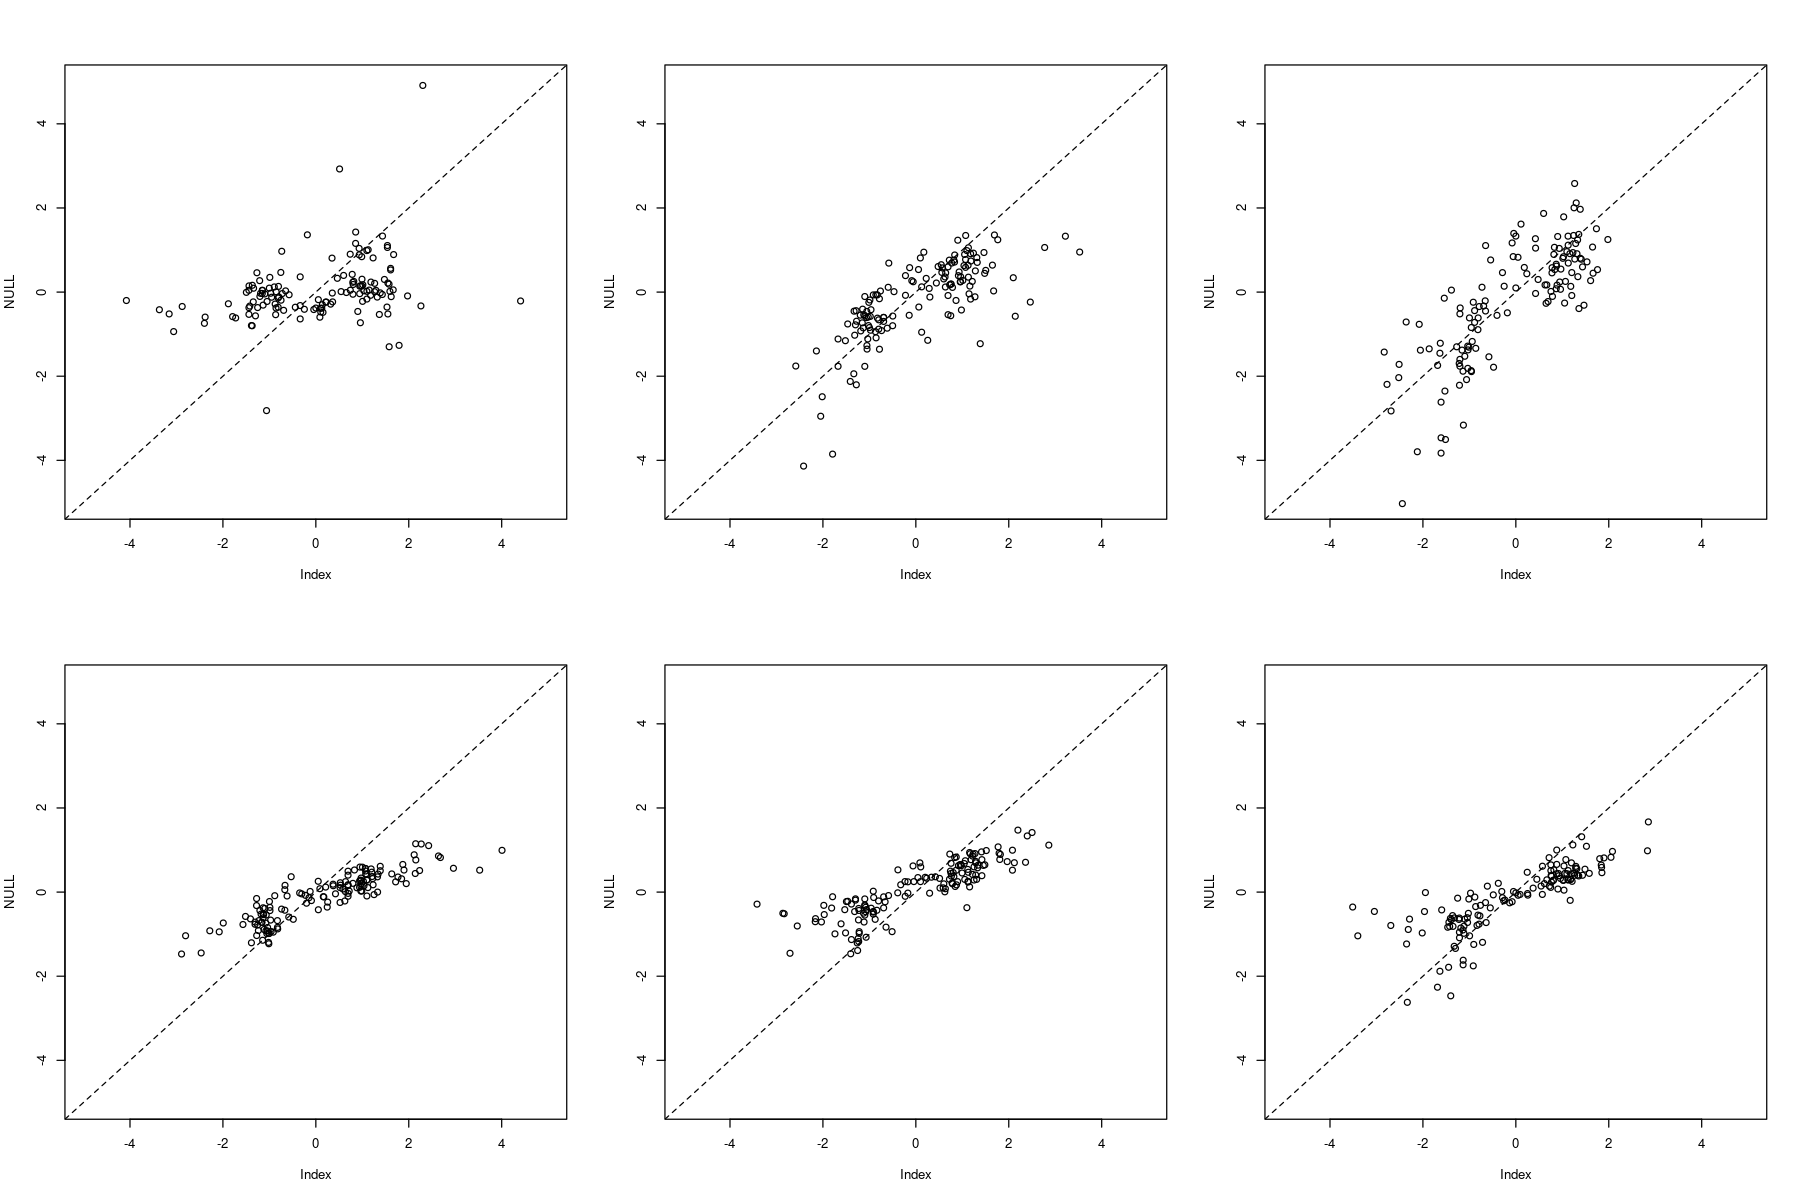

In [6]:
options(repr.plot.width=15,repr.plot.height=10)
layout(matrix(1:6,nrow=2))
for(bb in unique(pigeons$bird)){
    brd_data <- subset(pigeons,bird==bb)
    plot(NULL,xlim=c(-5,5),ylim=c(-5,5))
    abline(0,1,lty='dashed')
    points(log(brd_data$n_reinf_right/brd_data$n_reinf_left),
         log(brd_data$n_resp_right/brd_data$n_resp_left))
}

In [7]:
table(birds)

birds
  1   2   3   4   5   6 
137 145 142 146 135 136 

In [8]:
priors <- list(mean_alpha = 0.0,
               sd_alpha   = 1/sqrt(.1),
               mean_beta  = 0.0,
               sd_beta    = 1/sqrt(.1),
               shape_tau  = 2.0,
               rate_tau   = 0.5)

observed <- list(
    Br               = pigeons$n_resp_right,
    Bl               = pigeons$n_resp_left,
    Wr               = pigeons$n_reinf_right,
    Wl               = pigeons$n_reinf_left,
    #sessions         = sessions,
    birds            = birds,
    mean_alpha_prior = priors$mean_alpha,
    sd_alpha_prior   = priors$sd_alpha,
    mean_beta_prior  = priors$mean_beta,
    sd_beta_prior    = priors$sd_beta,
    shape_tau_prior  = priors$shape_tau,
    rate_tau_prior   = priors$rate_tau,
    n_obs            = length(sessions),
    n_birds          = length(unique(birds))
)
unobserved <- c('alpha', 'beta', 'tau', 'lambda_Br', 'lambda_Bl','log_B_post','Br_post','Bl_post')
write(
    'model{

    for(b in 1:n_birds){
         alpha[b] ~ dnorm(mean_alpha_prior, pow(sd_alpha_prior, -2))T(-2,2)
         beta[b]  ~ dnorm(mean_beta_prior , pow(sd_beta_prior , -2))T(-2,2)
         tau[b]   ~ dgamma(shape_tau_prior, rate_tau_prior)T(0.01,)
    }

    for(i in 1:n_obs){
             lambda_Br[i] ~ dlnorm( alpha[birds[i]]/2 + beta[birds[i]] * log(Wr[i])/2, tau[birds[i]])
             lambda_Bl[i] ~ dlnorm(-alpha[birds[i]]/2 - beta[birds[i]] * log(Wl[i])/2, tau[birds[i]])
             Br[i] ~ dpois(lambda_Br[i])
             Bl[i] ~ dpois(lambda_Bl[i])
    # Posterior predictive
             Br_post[i] ~ dpois(lambda_Br[i])
             Bl_post[i] ~ dpois(lambda_Bl[i])
             #Br_post[i,birds[i]] ~ dpois(lambda_Br[i])
             #Bl_post[i,birds[i]] ~ dpois(lambda_Bl[i])
           #  log_B_post[i] <- log(Br_post[i,birds[i]]/Bl_post[i,birsd[i]])
         }

    }','generative_matching_individual.bug'
  )
  bayes <- jags(
    data = observed,
    parameters.to.save = unobserved,
    model.file = 'generative_matching_individual.bug'
  )
  

module glm loaded



Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 1682
   Unobserved stochastic nodes: 3382
   Total graph size: 9163

Initializing model



Warning message in FUN(X[[i]], ...):
“Failed to set trace monitor for log_B_post
Variable log_B_post not found
”


In [9]:
pigeons[2:6,]

,session,bird,n_resp_left,n_resp_right,n_reinf_left,n_reinf_right,dynamic_env
,<chr>,<chr>,<int>,<int>,<int>,<int>,<lgl>
2,s02,p004,250,200,40,14,FALSE
3,s03,p004,6,112,3,5,FALSE
4,s04,p004,1,136,1,10,FALSE
5,s05,p004,130,507,24,20,FALSE
6,s06,p004,101,145,14,10,FALSE


In [10]:
summary(bayes$BUGSoutput$summary[,c('Rhat','n.eff')])

      Rhat           n.eff     
 Min.   :1.000   Min.   : 120  
 1st Qu.:1.001   1st Qu.:1400  
 Median :1.001   Median :3000  
 Mean   :1.002   Mean   :2264  
 3rd Qu.:1.002   3rd Qu.:3000  
 Max.   :1.018   Max.   :3000  

In [11]:
nds <- bayes$BUGSoutput$sims.list

In [12]:
names(nds)
dim(nds$alpha)
dim(nds$Br_post)

[1] "Bl_post"   "Br_post"   "alpha"     "beta"      "deviance"  "lambda_Bl"
[7] "lambda_Br" "tau"

[1] 3000    6

[1] 3000  841

In [13]:
summary(nds$alpha)
summary(nds$beta)

       V1                   V2                V3                V4         
 Min.   :-1.9999422   Min.   :-1.9987   Min.   :-1.9989   Min.   :-1.9991  
 1st Qu.:-0.9522081   1st Qu.:-1.4894   1st Qu.:-1.2579   1st Qu.:-1.0634  
 Median :-0.0001691   Median :-0.9057   Median :-0.5052   Median :-0.1347  
 Mean   :-0.0205610   Mean   :-0.7352   Mean   :-0.3490   Mean   :-0.1023  
 3rd Qu.: 0.8912882   3rd Qu.:-0.1602   3rd Qu.: 0.4361   3rd Qu.: 0.8058  
 Max.   : 1.9999925   Max.   : 1.9949   Max.   : 1.9973   Max.   : 1.9999  
       V5                V6         
 Min.   :-1.9941   Min.   :-1.9997  
 1st Qu.:-0.6610   1st Qu.:-0.4481  
 Median : 0.2400   Median : 0.4857  
 Mean   : 0.1766   Mean   : 0.3424  
 3rd Qu.: 1.0587   3rd Qu.: 1.2718  
 Max.   : 1.9989   Max.   : 1.9981  

       V1                 V2                 V3                 V4          
 Min.   :-1.40089   Min.   :-0.93068   Min.   :-1.11779   Min.   :-1.33909  
 1st Qu.:-0.29166   1st Qu.: 0.06585   1st Qu.:-0.20079   1st Qu.:-0.21532  
 Median : 0.01613   Median : 0.32768   Median : 0.11885   Median : 0.09083  
 Mean   : 0.01017   Mean   : 0.29223   Mean   : 0.08147   Mean   : 0.08082  
 3rd Qu.: 0.31155   3rd Qu.: 0.54114   3rd Qu.: 0.38122   3rd Qu.: 0.37792  
 Max.   : 1.28712   Max.   : 1.26628   Max.   : 1.21255   Max.   : 1.48492  
       V5                 V6          
 Min.   :-1.34120   Min.   :-1.32505  
 1st Qu.:-0.51566   1st Qu.:-0.49680  
 Median :-0.21366   Median :-0.20979  
 Mean   :-0.21238   Mean   :-0.18917  
 3rd Qu.: 0.08714   3rd Qu.: 0.09086  
 Max.   : 0.92917   Max.   : 1.13097  

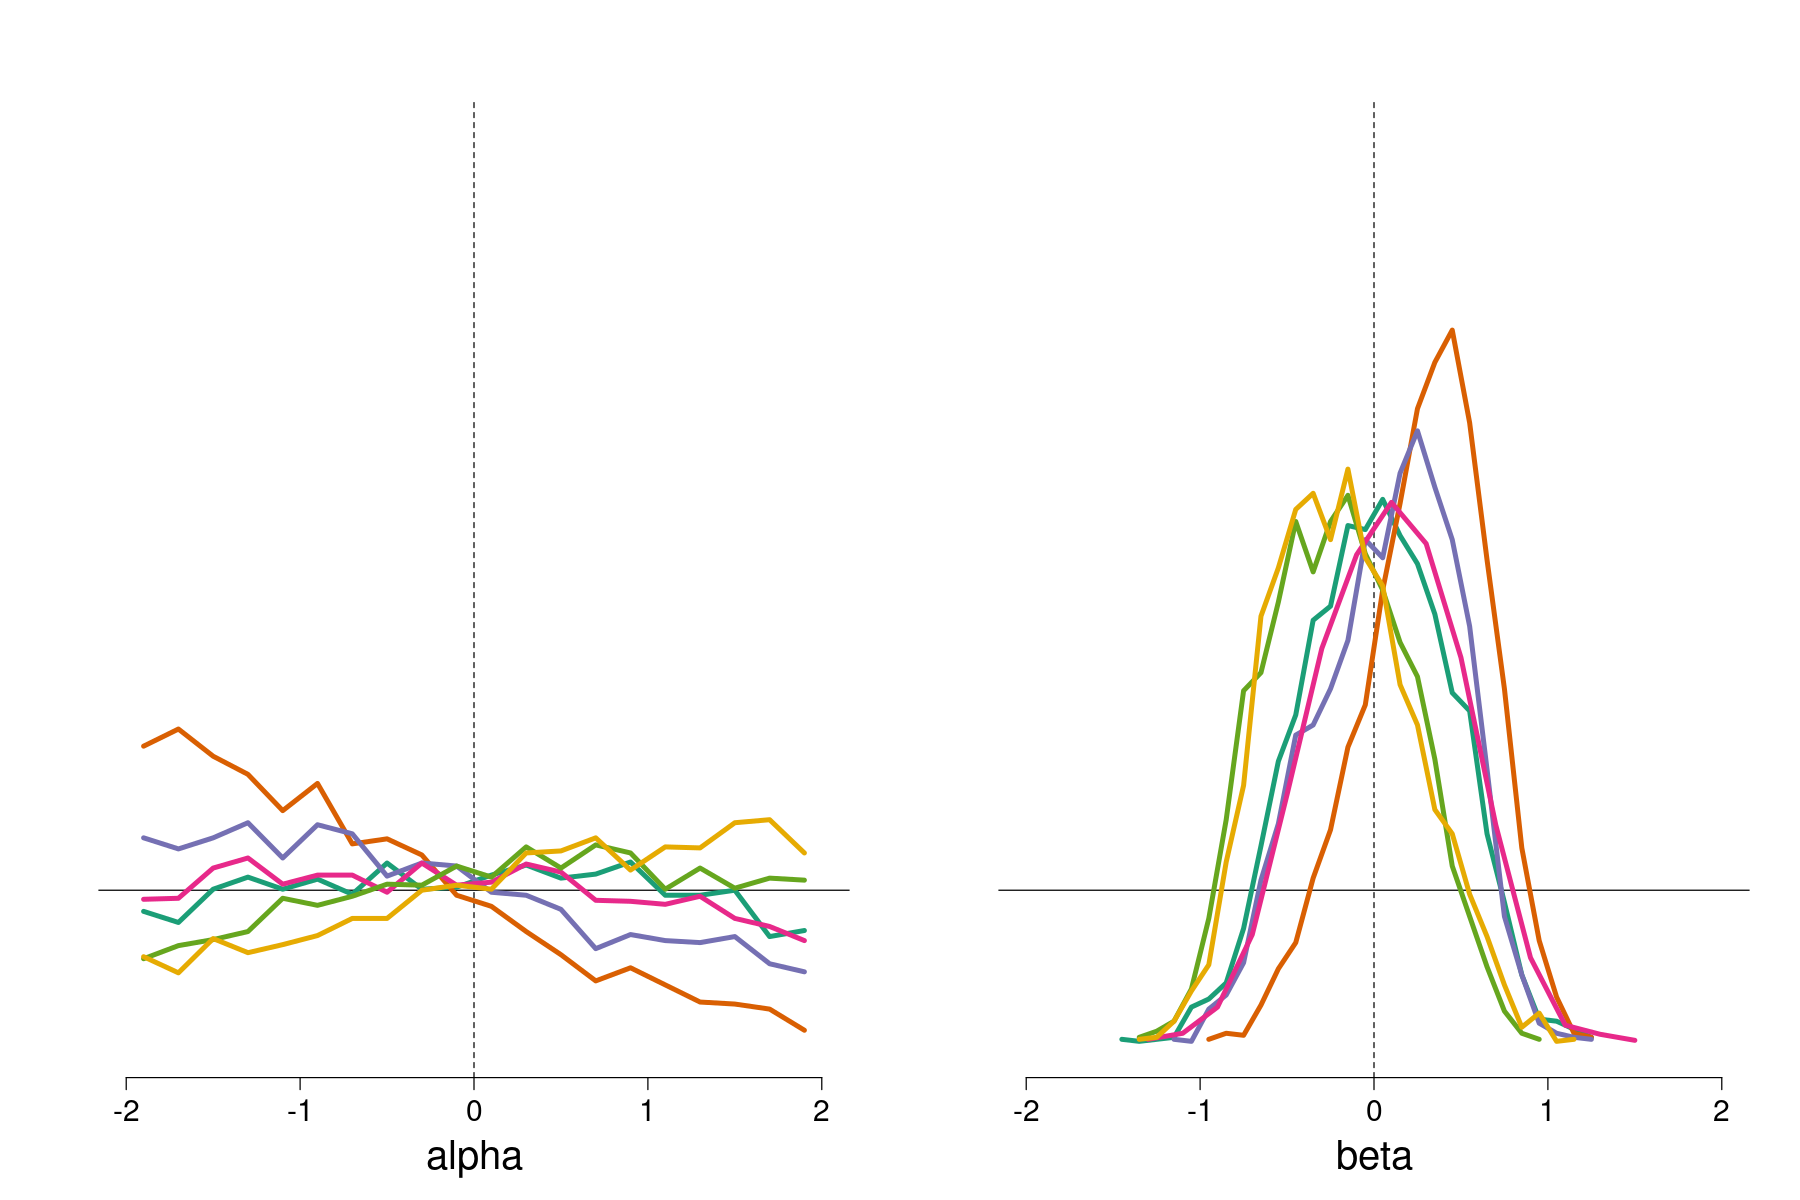

In [14]:
bird_colors <- c('#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02')

layout(matrix(1:2,nrow=1))

plot_marginal <- function(node){
    if(node=='alpha'){
        marginal = nds$alpha
    }
    else if(node=='beta'){
        marginal = nds$beta
    }
    plot(NULL,xlim=c(-2,2),ylim=c(0,1.5),axes=F,ann=F)
abline(v=0,lty='dashed')
    abline(h=.25)
par(cex.axis=1.5)
axis(1)
mtext(node,1,cex=2,line=3)
for(brd in 1:6){
    hist(marginal[,brd],breaks=20,plot=F)->ht
    lines(ht$mids,ht$density,lwd=4,col=bird_colors[brd])
    }
}

plot_marginal('alpha')
plot_marginal('beta')

In [15]:
birds

[1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [38] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [75] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[112] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
[149] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[186] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[223] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[260] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[297] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[334] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[371] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[408] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
[445] 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
[482] 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
[519] 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
[556] 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
[593] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
[630] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
[667] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
[704] 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
[741] 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
[778] 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
[815] 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6

In [16]:
dim(nds$alpha)

[1] 3000    6

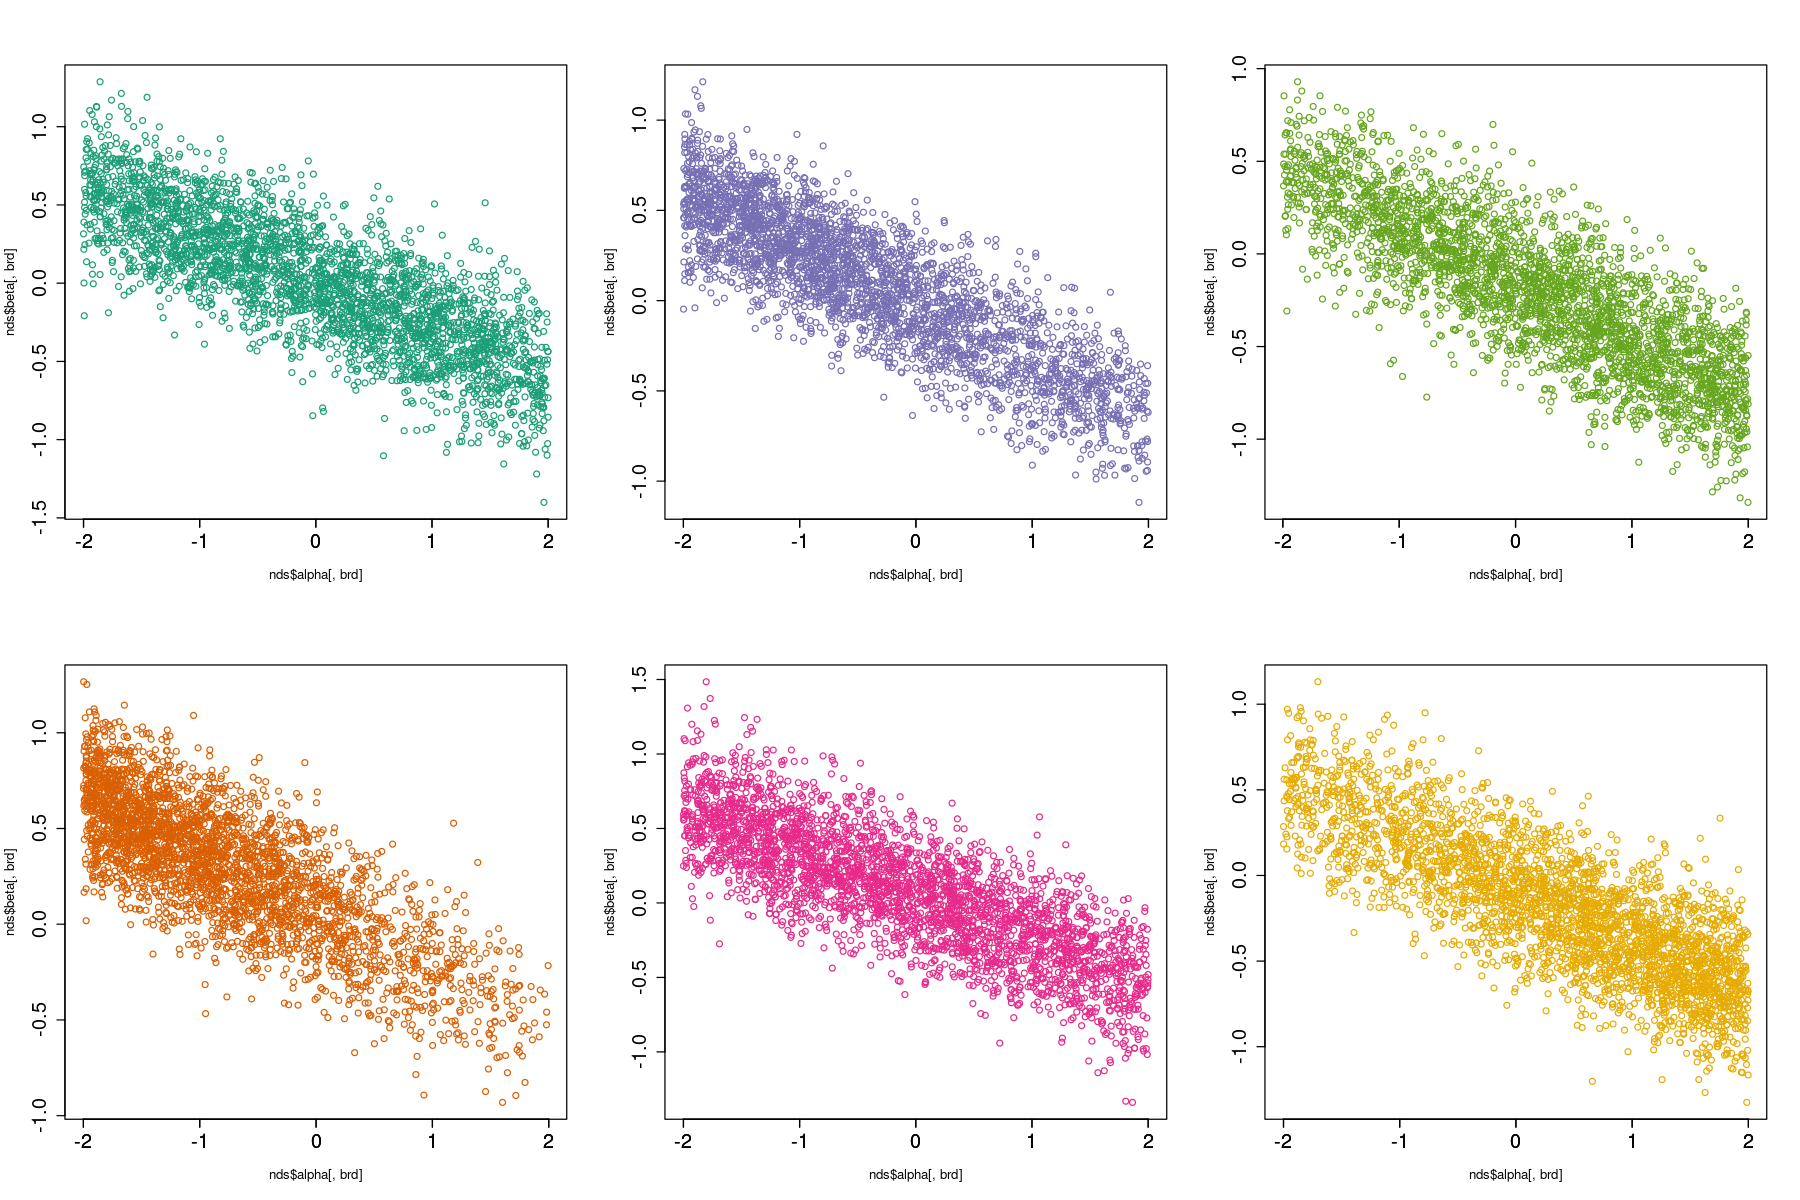

In [17]:
bird_colors <- c('#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02')

layout(matrix(1:2,nrow=1))

plot_marginal <- function(){

   # plot(NULL,xlim=c(-2,2),ylim=c(0,1.5),axes=F,ann=F)
#abline(v=0,lty='dashed')
par(cex.axis=1.5)
    layout(matrix(1:6,ncol=3))
for(brd in 1:6){
       plot(nds$alpha[,brd],nds$beta[,brd],col=bird_colors[brd])
    axis(1)

    }
}
plot_marginal()



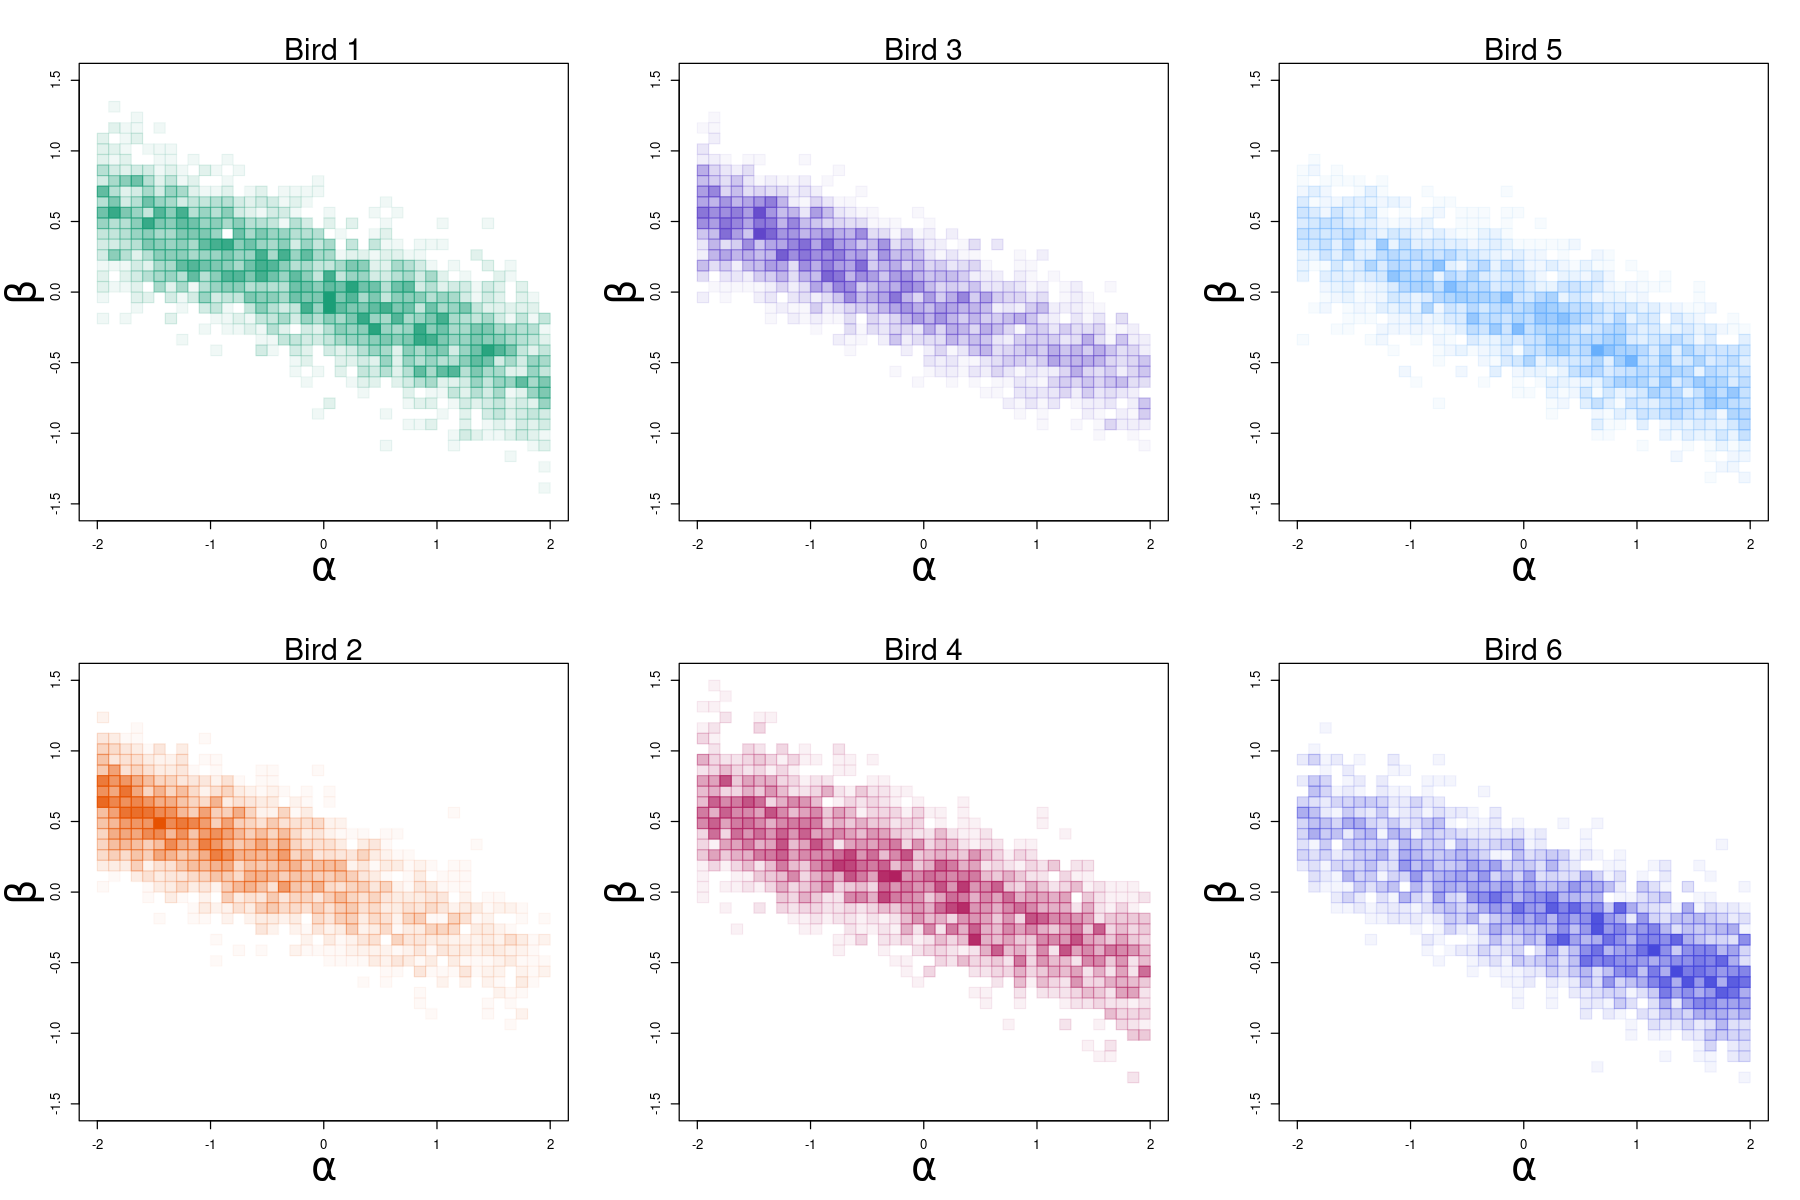

In [123]:
x <- nds$alpha[,2]
y <- nds$beta[,2]

to_hex <- function(int,digits=2){
    str <- as.character(as.hexmode(int))
    if(nchar(str)<digits){
        str <- paste('0',str,sep='')
    }
    return(str)
}


nice_scatter <- function(x,y,
                        color='#0044ee',
                        xlimz=NULL,
                        ylimz=NULL,
                         n_mids=40,
                        new_plot=T,
                        style='points',
                        point_scale=4,
                        raw_data=F){
    if(is.null(xlimz)){
        xlimz <- c(min(x),max(x))}
    if(is.null(ylimz)){
        ylimz <- c(min(y),max(y))}
  #  n_mids <- 30
    
    if(new_plot){
        plot(NULL,xlim=xlimz,ylim=ylimz,ann=F)
        if(raw_data){
            points(x,y,col='#cccccc')}
        }
    
    count_grid <- array(dim=c(n_mids,n_mids))
    x_brks <- seq(xlimz[1],xlimz[2],length.out = n_mids+1)
    y_brks <- seq(ylimz[1],ylimz[2],length.out = n_mids+1)
    x_width <- x_brks[2]-x_brks[1]
    y_width <- y_brks[2]-y_brks[1]
    x_mids <- x_brks[1:(length(x_brks)-1)]+x_width/2
    y_mids <- y_brks[1:(length(y_brks)-1)]+y_width/2
    for(i in 1:n_mids){
        for(j in 1:n_mids){
            # Counting
            count_grid[i,j] <- sum(x>=x_brks[i]
                                   &x<x_brks[(i+1)]
                                   &y>=y_brks[j]
                                   &y<y_brks[(j+1)])
        }
    }
    for(i in 1:n_mids){
        for(j in 1:n_mids){
            # Plotting
            alpha <- round(count_grid[i,j]*(255/max(count_grid)))
            # Squares of different sizes
            if(style=='points'){
                points(x_mids[i],y_mids[j],cex=point_scale*count_grid[i,j]/max(count_grid),
                       col=color,
                       pch=22,bg=paste(color,to_hex(alpha),sep=''))}
            # Polygons of different shades
            if(style=='polygon'){
                polygon(x=c(x_mids[i]+rep(c(-1,1),each=2)*x_width/2),
                        y=c(y_mids[j]+c(-1,1,1,-1)*y_width/2),
                        border=paste(color,to_hex(alpha),sep=''),
                        #border=NA,
                        col=paste(color,to_hex(alpha),sep=''))}
        }
    }
}

bird_colors <- c('#1b9e77','#e65201','#6146ca','#b12060','#68affc','#4749dc')
layout(matrix(1:6,ncol=3))
for(brd in 1:6){
    par(mar=c(5,5,4,2))
    nice_scatter(x=nds$alpha[,brd],
                 y=nds$beta[,brd],
                 color=bird_colors[brd],
                xlimz=c(-2,2),ylim=c(-1.5,1.5),
                style='polygon',raw_data=F)
    mtext(expression(alpha),1,cex=2,line=3)
    mtext(expression(beta),2,cex=2,line=2)
    mtext(paste('Bird',brd),3,cex=1.5)
}

In [20]:
round(15.4)

[1] 15

In [27]:
as.vector(matrix(1:9,ncol=3))
summary(as.vecmatrix(1:9,ncol=3))

[1] 1 2 3 4 5 6 7 8 9

       V1            V2            V3     
 Min.   :1.0   Min.   :4.0   Min.   :7.0  
 1st Qu.:1.5   1st Qu.:4.5   1st Qu.:7.5  
 Median :2.0   Median :5.0   Median :8.0  
 Mean   :2.0   Mean   :5.0   Mean   :8.0  
 3rd Qu.:2.5   3rd Qu.:5.5   3rd Qu.:8.5  
 Max.   :3.0   Max.   :6.0   Max.   :9.0  

In [21]:


dim(nds$Bl_post)
dim(nds$Br_post)

[1] 3000  841

[1] 3000  841

In [167]:
brd <- 2
brd_indexes <- which(birds==brd)
brd_data <- pigeons[brd_indexes,]
brd_data

,session,bird,n_resp_left,n_resp_right,n_reinf_left,n_reinf_right,dynamic_env
,<chr>,<chr>,<int>,<int>,<int>,<int>,<lgl>
181,s01,p054,236,277,33,17,FALSE
182,s02,p054,511,329,51,19,FALSE
183,s03,p054,271,247,26,14,FALSE
184,s04,p054,338,183,28,9,FALSE
185,s05,p054,143,206,17,10,FALSE
186,s06,p054,294,311,39,20,FALSE
187,s07,p054,309,110,25,7,FALSE
188,s08,p054,655,198,72,26,FALSE
189,s09,p054,306,118,25,10,FALSE
